In [81]:
from geopack import geopack
import numpy as np
import pylab as pl
import pandas as pd
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle
import seaborn as sns
from geopack import t96
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np
from ftplib import FTP_TLS

In [6]:
def get_dataframe_by_url_index():
    session = FTP_TLS('spdf.gsfc.nasa.gov')
    session.login()
    session.cwd('pub/data/omni/high_res_omni/')
    dir = 'https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/'
    urls = [dir + f[0] for f in session.mlsd() if f[0][-3:] == 'asc']
    session.quit()
    for i in range(len(urls)):
        print("number: ", i, " data: ", urls[i])
    index_number = int(input("select the number of your data (which corresponds to the year): "))


    if index_number >= len(urls):
        print("Index out of range.")
        return None

    dframe = pd.read_csv(urls[index_number], delim_whitespace=True, 
                         parse_dates={'datetime':[0,1,2,3]}, date_format='%Y %j %H %M',
                         usecols=[0, 1, 2, 3, 14, 17, 18, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33],
                         names=['Year','Day','Hour','Minute', 'Bx,GSM', 'By,GSM', 'Bz,GSM', 'Flow Speed',
                                'Vx,GSE', 'Vy,GSE', 'Vz,GSE', 'Proton Density', 'Flow Pressure',
                                'Electric Field', 'Plasma Beta', 'Alfven Mach Number',
                                'x,GSE', 'y,GSE', 'z,GSE']).set_index('datetime').sort_index()
    return dframe


In [7]:
dframe = get_dataframe_by_url_index()

number:  0  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_5min2005.asc
number:  1  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_min2012.asc
number:  2  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_min2015.asc
number:  3  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_5min2002.asc
number:  4  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_min1982.asc
number:  5  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_5min1995.asc
number:  6  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_5min1992.asc
number:  7  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_min1985.asc
number:  8  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_min2020.asc
number:  9  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_5min2021.asc
number:  10  data:  https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_5min1

# 2D Plot

In [198]:
def calc_ut(string):
    t1 = parser.parse(string)
    t0 = datetime(1970, 1, 1)
    ut = int((t1-t0).total_seconds())
    return ut

def process_data_and_plot(df, start_time, probint=int, Dst_val=float, save_figure=False, dirname=None, timesteps=int, x_cut=float):
    
    df = df[df["x,GSE"] < 1000] # Clear out messed up data
    
    start_datetime = parser.parse(start_time)
    Timesteps = timesteps
    ScalingTerm = np.arange(0, len(df)) < Timesteps
    Pdyn = df['Flow Pressure'][ScalingTerm]
    By_gsm = df['By,GSM'][ScalingTerm]
    Bz_gsm = df['Bz,GSM'][ScalingTerm]
    By_gsm = df['By,GSM'][ScalingTerm]
    Vx = df['Vx,GSE'][ScalingTerm]
    Vy = df['Vy,GSE'][ScalingTerm]
    Vz = df['Vz,GSE'][ScalingTerm]
    
    
    Ind = np.arange(0, Timesteps)
#     Be = np.zeros((3, Timesteps))
#     Bi = np.zeros((3, len(Pdyn)))
    IMFCA = np.zeros(Timesteps)

    YZ_Resolution = 100
    Extension = 30
    Ex = Extension/2
    Dy = np.linspace(-Ex, Ex, YZ_Resolution)
    Dz = np.linspace(-Ex, Ex, YZ_Resolution)
    
    Dst = Dst_val
    Bex = np.zeros((len(Pdyn), len(Dy), len(Dz)))
    Bix = np.zeros((len(Pdyn), len(Dy), len(Dz)))
    Bey = np.zeros((len(Pdyn), len(Dy), len(Dz)))
    Biy = np.zeros((len(Pdyn), len(Dy), len(Dz)))
    Bez = np.zeros((len(Pdyn), len(Dy), len(Dz)))
    Biz = np.zeros((len(Pdyn), len(Dy), len(Dz)))
    
    theta_shearArr = np.zeros((len(Pdyn), len(Dy), len(Dz)))

    for ind, pdyn, by, bz, vx, vy, vz in zip(Ind, Pdyn, By_gsm, Bz_gsm, Vx, Vy, Vz):
        par = np.array([pdyn, Dst, by, bz, 0, 0, 0, 0, 0, 0])
        y = z = 0
        x = x_cut
        
        vgse = (vx, vy, vz)
        
        current_time = start_datetime + timedelta(minutes=int(probint * ind))
        ut = calc_ut(str(current_time))
        ps = geopack.recalc(ut, vx, vy, vz)
        
        IMFCA[ind] = np.arctan2(by, bz)
        
        for iz, dz in enumerate(Dz):
            for iy, dy in enumerate(Dy):
                dBe = geopack.t96.t96(par, ps, x, y+dy, z+dz)
                dBi = geopack.dip(x, y+dy, z+dz)
                Bex[ind, iy, iz], Bey[ind, iy, iz], Bez[ind, iy, iz] = dBe
                Bix[ind, iy, iz], Biy[ind, iy, iz], Biz[ind, iy, iz] = dBi
                theta_shearArr[ind, iy, iz] = np.arccos(cosarg)
                cosarg = round(np.dot(dBe, dBi)/ (np.linalg.norm(dBi) * np.linalg.norm(dBe)), 8)
                theta_shearArr[ind, iy, iz] = np.arccos(cosarg)
                theta_shearArr[ind, iy, iz] = np.degrees(theta_shearArr[ind, iy, iz])
                
                if np.isnan(theta_shearArr[ind, iy, iz]):
                    if np.dot(dBe, dBi) / (np.linalg.norm(dBi) * np.linalg.norm(dBe)) < -1.0:
                        theta_shearArr[ind, iy, iz] = np.pi
                    elif np.dot(dBe, dBi)/ (np.linalg.norm(dBi) * np.linalg.norm(dBe)) > 1:
                        theta_shearArr[ind, iy, iz] = 0

    # plotting and saving part
    if save_figure:
        if not os.path.exists(dirname):
            os.makedirs(dirname)

    for i in range(len(theta_shearArr[:, 0, 0])):
    #for i in range(len(Be[:, 0, 0])):
        
        data = theta_shearArr[i, :, :]
        data = Be[i, :, :]
        plt.imshow(data.T, cmap='jet', vmin=0, vmax=180, extent=[-Ex, Ex, -Ex, Ex])  # extent is used to define the span of x and y axes

        # Set labels and tickmarks
        plt.xlabel(r"$Y_{GSM}$ (Re)")
        plt.ylabel(r"$Z_{GSM}$ (Re)")
        plt.xticks(np.linspace(-Ex, Ex, 5))  # Change the number 5 for more or fewer tick marks
        plt.yticks(np.linspace(-Ex, Ex, 5))

        plt.colorbar(label=r'$\theta_{shear}$')

        legend_text = r"$\theta_{IMF}$" + f" = {np.degrees(IMFCA[i]):.2f}"
        plt.text(0.1, 0.1, legend_text, transform=plt.gca().transAxes, color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

        current_datetime = start_datetime + timedelta(minutes=probint*i)
        title_text = f"Magnetopause at: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')}"
        plt.title(title_text)

        # Add subtitle
        # plt.suptitle("177º + is a reconnection site!", y=1.004, fontsize=12, color='red')

        if save_figure:
            plt.savefig(f'{dirname}/plot_{i}.png', dpi=300, bbox_inches='tight')
        plt.show()

Make a Movie:

In [176]:
import os
import imageio

os.environ['IMAGEIO_FFMPEG_EXE'] = "/opt/homebrew/bin/ffmpeg"

def make_movie(directory=str, fps=int, name=str):
    # List all files in the directory
    # env at /opt/homebrew/bin/ffmpeg
    files = os.listdir(directory)
    
    # Filter and sort the files based on naming pattern 'plot_{number}.png'
    sorted_files = sorted([f for f in files if f.startswith('plot_') and f.endswith('.png')],
                          key=lambda x: int(x.split('_')[1].split('.')[0]))
    
    # Create a full path for each image file
    image_files = [os.path.join(directory, f) for f in sorted_files]
    
    # Create a movie using imageio's mimsave function
    with imageio.get_writer(f'{name}.mp4', fps=fps) as writer:
        for image_file in image_files:
            image = imageio.imread(image_file)
            writer.append_data(image)

Make 2D plot with traced magnetic field lines

In [177]:
def calc_ut(string):
    t1 = parser.parse(string)
    t0 = datetime(1970, 1, 1)
    ut = int((t1-t0).total_seconds())
    return ut

def process_data_and_plot_and_trace(df, start_time, probint=int, Dst_val=float, save_figure=False, dirname=None, timesteps=int, x_cut=float):
    
    df = df[df["x,GSE"] < 1000]
    
    
    
    start_datetime = parser.parse(start_time)
    
    Timesteps = timesteps
    ScalingTerm = np.arange(0, len(df)) < Timesteps
    Pdyn = df['Flow Pressure'][ScalingTerm]
    By_gsm = df['By,GSM'][ScalingTerm]
    Bz_gsm = df['Bz,GSM'][ScalingTerm]
    By_gsm = df['By,GSM'][ScalingTerm]
    Vx = df['Vx,GSE'][ScalingTerm]
    Vy = df['Vy,GSE'][ScalingTerm]
    Vz = df['Vz,GSE'][ScalingTerm]
    
    
    Ind = np.arange(0, Timesteps)
    Be = np.zeros((3, Timesteps))
    Bi = np.zeros((3, len(Pdyn)))
    IMFCA = np.zeros(Timesteps)

    YZ_Resolution = 60
    Extension = 30
    Ex = Extension/2
    Dy = np.linspace(-Ex, Ex, YZ_Resolution)
    Dz = np.linspace(-Ex, Ex, YZ_Resolution)
    
    Dst = Dst_val

    x_north, y_north, z_north = generate_random_points_on_hemisphere('north', 20)
    x_south, y_south, z_south = generate_random_points_on_hemisphere('south', 20)
    

    theta_shearArr = np.zeros((len(Pdyn), len(Dy), len(Dz)))

    for ind, pdyn, by, bz, vx, vy, vz in zip(Ind, Pdyn, By_gsm, Bz_gsm, Vx, Vy, Vz):
        par = np.array([pdyn, Dst, by, bz, 0, 0, 0, 0, 0, 0])
        y = z = 0
        x = x_cut
        

        
        vgse = (vx, vy, vz)
        
        current_time = start_datetime + timedelta(minutes=int(probint * ind))
        ut = calc_ut(str(current_time))
        ps = geopack.recalc(ut, vx, vy, vz)
        
        IMFCA[ind] = np.arctan2(by, bz)
        
        for iz, dz in enumerate(Dz):
            for iy, dy in enumerate(Dy):
                dBe = geopack.t96.t96(par, ps, x, y+dy, z+dz)
                dBi = geopack.dip(x, y+dy, z+dz)
                cosarg = round(np.dot(dBe, dBi)/ (np.linalg.norm(dBi) * np.linalg.norm(dBe)), 8)
                theta_shearArr[ind, iy, iz] = np.arccos(cosarg)
                theta_shearArr[ind, iy, iz] = np.degrees(theta_shearArr[ind, iy, iz])
                
                if np.isnan(theta_shearArr[ind, iy, iz]):
                    if np.dot(dBe, dBi) / (np.linalg.norm(dBi) * np.linalg.norm(dBe)) < -1.0:
                        theta_shearArr[ind, iy, iz] = np.pi
                    elif np.dot(dBe, dBi)/ (np.linalg.norm(dBi) * np.linalg.norm(dBe)) > 1:
                        theta_shearArr[ind, iy, iz] = 0

    # plotting and saving part
    if save_figure:
        if not os.path.exists(dirname):
            os.makedirs(dirname)

    for i in range(len(theta_shearArr[:, 0, 0])):
        
        
        data = theta_shearArr[i, :, :]
        plt.imshow(data.T, cmap='jet', vmin=0, vmax=180, extent=[-Ex, Ex, -Ex, Ex])  # extent is used to define the span of x and y axes

        # Set labels and tickmarks
        plt.xlabel(r"$Y_{GSM}$ (Re)")
        plt.ylabel(r"$Z_{GSM}$ (Re)")
        plt.xticks(np.linspace(-Ex, Ex, 5))  # Change the number 5 for more or fewer tick marks
        plt.yticks(np.linspace(-Ex, Ex, 5))
        
        for x_gsm, y_gsm, z_gsm in zip(x_north, y_north, z_north):
            x, y, z, xx, yy, zz = geopack.trace(x_gsm, y_gsm, z_gsm, dir=1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
            within_boundaries = (-Ex <= yy) & (yy <= Ex) & (-Ex <= zz) & (zz <= Ex)
            plt.plot(np.array(yy)[within_boundaries], np.array(zz)[within_boundaries], color='magenta')  # Using blue for northern hemisphere
        
        # Plot the magnetic field lines for southern hemisphere points
        for x_gsm, y_gsm, z_gsm in zip(x_south, y_south, z_south):
            x, y, z, xx, yy, zz = geopack.trace(x_gsm, y_gsm, z_gsm, dir=-1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
            within_boundaries = (-Ex <= yy) & (yy <= Ex) & (-Ex <= zz) & (zz <= Ex)
            plt.plot(np.array(yy)[within_boundaries], np.array(zz)[within_boundaries], color='magenta')  # Using blue for northern

        plt.colorbar(label=r'$\theta_{shear}$')

        legend_text = r"$\theta_{IMF}$" + f" = {np.degrees(IMFCA[i]):.2f}"
        plt.text(0.1, 0.1, legend_text, transform=plt.gca().transAxes, color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

        current_datetime = start_datetime + timedelta(minutes=probint*i)
        title_text = f"Magnetopause at: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')}"
        plt.title(title_text)

        # Add subtitle
        #plt.suptitle("177º + is a reconnection site!", y=1.004, fontsize=12, color='red')

        if save_figure:
            plt.savefig(f'dirname/cool.png', dpi=300, bbox_inches='tight')
        plt.show()


3D Plot

In [178]:
def plot_3D(df, start_time, probint=int, Dst_val=float, save_figure=False, dirname=None, timesteps=int, cut=float, var=str):
    
    df = df[df["x,GSE"] < 1000]
    
    start_datetime = parser.parse(start_time)
    Timesteps = timesteps
    ScalingTerm = np.arange(0, len(df)) < Timesteps
    Pdyn = df['Flow Pressure'][ScalingTerm]
    By_gsm = df['By,GSM'][ScalingTerm]
    Bz_gsm = df['Bz,GSM'][ScalingTerm]
    By_gsm = df['By,GSM'][ScalingTerm]
    Vx = df['Vx,GSE'][ScalingTerm]
    Vy = df['Vy,GSE'][ScalingTerm]
    Vz = df['Vz,GSE'][ScalingTerm]
    
    
    Ind = np.arange(0, Timesteps)
    Be = np.zeros((3, Timesteps))
    Bi = np.zeros((3, len(Pdyn)))
    IMFCA = np.zeros(Timesteps)

    XYZ_Resolution = 30
    Extension = 30
    Ex = Extension/2
    
    Dx = np.linspace(-Ex, Ex, XYZ_Resolution)
    Dy = np.linspace(-Ex, Ex, XYZ_Resolution)
    Dz = np.linspace(-Ex, Ex, XYZ_Resolution)
    
    Dst = Dst_val
    
    theta_shearArr = np.zeros((len(Pdyn), len(Dx), len(Dy), len(Dz)))

    for ind, pdyn, by, bz, vx, vy, vz in zip(Ind, Pdyn, By_gsm, Bz_gsm, Vx, Vy, Vz):
        par = np.array([pdyn, Dst, by, bz, 0, 0, 0, 0, 0, 0])
        y = z = x = 0
        
        vgse = (vx, vy, vz) # Flow Velocity in GSE
        
        current_time = start_datetime + timedelta(minutes=int(probint * ind))
        ut = calc_ut(str(current_time))
        ps = geopack.recalc(ut, vx, vy, vz)
        
        IMFCA[ind] = np.arctan2(by, bz)
        
        for iz, dz in enumerate(Dz):
            for iy, dy in enumerate(Dy):
                for ix, dx in enumerate(Dx):
                    
                    dBe = geopack.t96.t96(par, ps, x+dx, y+dy, z+dz)
                    dBi = geopack.dip(x+dx, y+dy, z+dz)
                    cosarg = round(np.dot(dBe, dBi)/ (np.linalg.norm(dBi) * np.linalg.norm(dBe)), 8)
                    theta_shearArr[ind, ix, iy, iz] = np.arccos(cosarg)
                    theta_shearArr[ind, ix, iy, iz] = np.degrees(theta_shearArr[ind, ix, iy, iz])

                    if np.isnan(theta_shearArr[ind, ix, iy, iz]):
                        if np.dot(dBe, dBi) / (np.linalg.norm(dBi) * np.linalg.norm(dBe)) < -1.0:
                            theta_shearArr[ind, iy, iz] = np.pi
                        elif np.dot(dBe, dBi)/ (np.linalg.norm(dBi) * np.linalg.norm(dBe)) > 1:
                            theta_shearArr[ind, iy, iz] = 0

    # plotting and saving part
    if save_figure:
        if not os.path.exists(dirname):
            os.makedirs(dirname)

    for i in range(len(theta_shearArr[:, 0, 0, 0])):
        
        if var == "yz":
            data = theta_shearArr[i, cut, :, :] # Y and Z in that order    (First in X axis and second in Y axis)
        elif var == "xz":
            data = theta_shearArr[i, :, cut, :] # X and Z in that order
        elif var == "xy":
            data = theta_shearArr[i, :, :, cut] # X and Y in that order
        elif var == "yx":
            data = theta_shearArr[i, :, :, cut].T # Y and X in that order
        elif var == "zx":
            data = theta_shearArr[i, :, cut, :].T # Z and X in that order
        elif var == "zy":
            data = theta_shearArr[i, cut, :, :].T # Z and Y in that order
            
    
        plt.imshow(data.T, cmap='jet', vmin=0, vmax=180, extent=[-Ex, Ex, -Ex, Ex])  # extent is used to define the span of x and y axes

        # Set labels and tickmarks
        
        plt.xlabel(r"$Y_{GSM}$ (Re)")
        plt.ylabel(r"$Z_{GSM}$ (Re)")
        plt.xticks(np.linspace(-Ex, Ex, 5))  # Change the number 5 for more or fewer tick marks
        plt.yticks(np.linspace(-Ex, Ex, 5))

        plt.colorbar(label=r'$\theta_{shear}$')

        legend_text = r"$\theta_{IMF}$" + f" = {np.degrees(IMFCA[i]):.2f}"
        plt.text(0.1, 0.1, legend_text, transform=plt.gca().transAxes, color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

        current_datetime = start_datetime + timedelta(minutes=probint*i)
        title_text = f"Magnetopause at: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')}"
        plt.title(title_text)

        # Add subtitle
        # plt.suptitle("177º + is a reconnection site!", y=1.004, fontsize=12, color='red')

        if save_figure:
            plt.savefig(f'{dirname}/plot_{i}.png', dpi=300, bbox_inches='tight')
        plt.show()


In [325]:
def calc_ut(string):
    t1 = parser.parse(string)
    t0 = datetime(1970, 1, 1)
    ut = int((t1-t0).total_seconds())
    return ut

def plot_2D_any(df, start_time, probint=int, Dst_val=float, save_figure=False, dirname=None, timesteps=int, cut=float, wtp="shear", var=str, resolution=int):
    
    df = df[df["x,GSE"] < 1000]
    
    start_datetime = parser.parse(start_time)
    Timesteps = timesteps
    ScalingTerm = np.arange(0, len(df)) < Timesteps
    Pdyn = df['Flow Pressure'][ScalingTerm]
    By_gsm = df['By,GSM'][ScalingTerm]
    Bz_gsm = df['Bz,GSM'][ScalingTerm]
    By_gsm = df['By,GSM'][ScalingTerm]
    Vx = df['Vx,GSE'][ScalingTerm]
    Vy = df['Vy,GSE'][ScalingTerm]
    Vz = df['Vz,GSE'][ScalingTerm]
    
    
    Ind = np.arange(0, Timesteps)
    Be = np.zeros((3, Timesteps))
    Bi = np.zeros((3, len(Pdyn)))
    IMFCA = np.zeros(Timesteps)

    XYZ_Resolution = resolution
    Extension = 30
    Ex = Extension/2
    
    D1 = np.linspace(-Ex, Ex, XYZ_Resolution)
    D2 = np.linspace(-Ex, Ex, XYZ_Resolution)
    
    Bex = np.zeros((len(Pdyn), len(D2), len(D1)))
    Bix = np.zeros((len(Pdyn), len(D2), len(D1)))
    Bey = np.zeros((len(Pdyn), len(D2), len(D1)))
    Biy = np.zeros((len(Pdyn), len(D2), len(D1)))
    Bez = np.zeros((len(Pdyn), len(D2), len(D1)))
    Biz = np.zeros((len(Pdyn), len(D2), len(D1)))

    Dst = Dst_val
    
    theta_shearArr = np.zeros((len(Pdyn), len(D2), len(D1)))

    for ind, pdyn, by, bz, vx, vy, vz in zip(Ind, Pdyn, By_gsm, Bz_gsm, Vx, Vy, Vz):
        par = np.array([pdyn, Dst, by, bz, 0, 0, 0, 0, 0, 0])
        
        
        vgse = (vx, vy, vz) # Flow Velocity in GSE
        
        current_time = start_datetime + timedelta(minutes=int(probint * ind))
        ut = calc_ut(str(current_time))
        ps = geopack.recalc(ut, vx, vy, vz)
        
        IMFCA[ind] = np.arctan2(by, bz)
        
        for i1, d1 in enumerate(D1):
            for i2, d2 in enumerate(D2):
                
                
                if var=='yz' or var=='zy':
                    
                    x = cut
                    y = z = 0
                    
                    dBe = geopack.t96.t96(par, ps, x, y+d2, z+d1)
                    dBi = geopack.dip(x, y+d2, z+d1) # Y vs Z (x axis y axis)


                if var=='yx' or var=='xy':
                    
                    z = cut
                    y = x = 0
                    
                    dBe = geopack.t96.t96(par, ps, x+d1, y+d2, z)
                    dBi = geopack.dip(x+d1, y+d2, z) # Y vs X (x axis y axis)
                    

                if var=='xz' or var=='zx':
                    
                    y = cut
                    x = z = 0
                    
                    dBe = geopack.t96.t96(par, ps, x+d1, y, z+d2)
                    dBi = geopack.dip(x+d1, y, z+d2) # Z vs X

      
                if wtp.startswith("b"):
                    Bex[ind, i2, i1], Bey[ind, i2, i1], Bez[ind, i2, i1] = dBe
                    Bix[ind, i2, i1], Biy[ind, i2, i1], Biz[ind, i2, i1] = dBi
                else:
                    cosarg = round(np.dot(dBe, dBi)/ (np.linalg.norm(dBi) * np.linalg.norm(dBe)), 8)
                    theta_shearArr[ind, i2, i1] = np.arccos(cosarg)
                    theta_shearArr[ind, i2, i1] = np.degrees(theta_shearArr[ind, i2, i1])
        

                    if np.isnan(theta_shearArr[ind, i2, i1]):
                        if np.dot(dBe, dBi) / (np.linalg.norm(dBi) * np.linalg.norm(dBe)) < -1.0:
                            theta_shearArr[ind, i2, i1] = 180
                        elif np.dot(dBe, dBi)/ (np.linalg.norm(dBi) * np.linalg.norm(dBe)) > 1:
                            theta_shearArr[ind, i2, i1] = 0

    # plotting and saving part
    if save_figure:
        if not os.path.exists(dirname):
            os.makedirs(dirname)

    for i in range(Timesteps):
        
        plt.figure(figsize=(7, 5))
        
        
        if wtp.startswith("b"):
            if wtp == "bex":
                data = Bex[i, :, :]
            if wtp == "bey":
                data = Bey[i, :, :]
            if wtp == "bez":
                data = Bez[i, :, :]
            if wtp == "bix":
                data = Bex[i, :, :]
            if wtp == "biy":
                data = Biy[i, :, :]
            if wtp == "biz":
                data = Biz[i, :, :]
            
        else:
            data = theta_shearArr[i, :, :]
            
        if var=="xz" or var=="xy" or var=="zy":
            data = data.T
        else:
            data = data
        print(data.shape)
        
      
        plt.imshow(data.T, cmap='jet', vmin=np.min(data), vmax=np.max(data), extent=[-Ex, Ex, -Ex, Ex])  # extent is used to define the span of x and y axes

        # Set labels and tickmarks
        
        if var == "xy":
            plt.xlabel(r"$X_{GSM}$ (Re)")
            plt.ylabel(r"$Y_{GSM}$ (Re)")
        elif var == "xz":
            plt.xlabel(r"$X_{GSM}$ (Re)")
            plt.ylabel(r"$Z_{GSM}$ (Re)")
        elif var == "yx":
            plt.xlabel(r"$Y_{GSM}$ (Re)")
            plt.ylabel(r"$X_{GSM}$ (Re)")
        elif var == "yz":
            plt.xlabel(r"$Y_{GSM}$ (Re)")
            plt.ylabel(r"$Z_{GSM}$ (Re)")
        elif var == "zx":
            plt.xlabel(r"$Z_{GSM}$ (Re)")
            plt.ylabel(r"$X_{GSM}$ (Re)")
        elif var == "zy":
            plt.xlabel(r"$Z_{GSM}$ (Re)")
            plt.ylabel(r"$Y_{GSM}$ (Re)")
        else:
            raise ValueError("Invalid value for 'var'.")

        plt.xticks(np.linspace(-Ex, Ex, 5))  # Change the number 5 for more or fewer tick marks
        plt.yticks(np.linspace(-Ex, Ex, 5))
        
        if wtp.startswith("shear"):
            plt.colorbar(label=r'$\theta_{shear}$')
        elif wtp == "bex":
            plt.colorbar(label=r'$B_{ex}$')
            
        elif wtp == "bey":
            plt.colorbar(label=r'$B_{ey}$')
            
        elif wtp == "bez":
            plt.colorbar(label=r'$B_{ez}$')
            
        elif wtp == "bix":
            plt.colorbar(label=r'$B_{ix}$')
            
        elif wtp == "biy":
            plt.colorbar(label=r'$B_{iy}$')
        
        elif wtp == "biz":
            plt.colorbar(label=r'$B_{iz}$')
            
        legend_text = r"$\theta_{IMF}$" + f" = {np.degrees(IMFCA[i]):.2f}"
        plt.text(0.1, 0.1, legend_text, transform=plt.gca().transAxes, color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

        current_datetime = start_datetime + timedelta(minutes=probint*i)
        title_text = f"Magnetopause at: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')}"
        plt.title(title_text)


        
        if save_figure:
            plt.savefig(f'{dirname}/plot_{i}.png', dpi=300, bbox_inches='tight')
        #plt.show()


In [330]:
def make_one_time_movie(df, start_time=stime, probint=5, Dst_val=int, dirname="movietime", wtp="shear", var='yz', resolution=100, st=float, en=float, iv=float, fps=10, name=str):
    num = 0
    for value in np.arange(st, en, iv):
        plot_2D_any(df=df, start_time=stime, dirname=dirname, probint=5, Dst_val=Dst_val, timesteps=1, cut=value, wtp=wtp, var=var, resolution=resolution)
        plt.savefig(f"movietime/plot_{num}.png", dpi=300) # bbox_inches='tight'
        plt.show()
        num+=1
        
    make_movie(directory=dirname, fps=fps, name=name)
    

# Get Data

dframe = get_dataframe_by_url_index()

# Start time of Data

stime = '2006-01-30 16:30:00'

# Just plot the 2D cut Y vs Z axes at a certain  

process_data_and_plot(df=df1, start_time=stime, probint=5, Dst_val=-5, save_figure=True, dirname="movietime", timesteps=1, x_cut=6)

# Make a movie

make_movie(directory="movietime", fps=10, name="plot") # directory from which to get frames, fps, moviename. based on naming pattern 'plot_{number}.png'

# Plot 2D cut and trace

process_data_and_plot_and_trace(df=df1, start_time=stime, probint=5, Dst_val=-5, save_figure=False, dirname="movietime", timesteps=6, x_cut=6)

# Load all dims and plot 2D

plot_3D(df=df1, start_time=stime, probint=5, Dst_val=-5, save_figure=False, dirname="movietime", timesteps=1, cut=6, var='yx')

# Load 2D and plot any 2D combination including int and ext B fields

plot_2D_any(df=df1, start_time=stime, probint=5, Dst_val=-5, save_figure=False, dirname="movietime", timesteps=1, cut=6, wtp="bex", var='zx', resolution=100)

# Make a movie of one time datapoint

make_one_time_movie(df=df1, start_time=stime, probint=5, Dst_val=int, dirname="movietime", wtp="shear", var='yz', resolution=100, s=float, e=float, i=float) 
Make a movie in one point in time. If you want to go from a higher "s" start > to a lower "e" end, use negative "i" interval.

(100, 100)


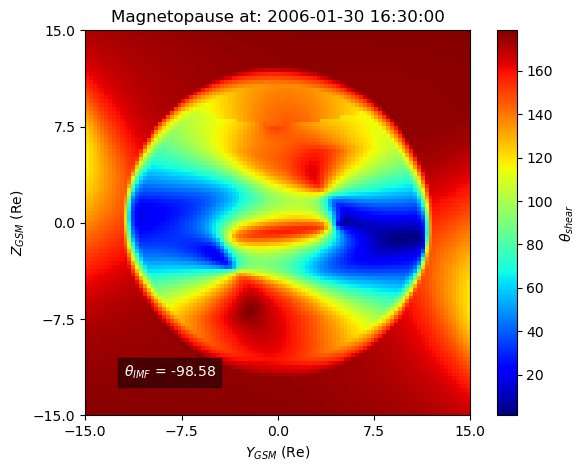

In [437]:
stime = '2006-01-30 16:30:00'

# make_one_time_movie(df=df1, start_time=stime, Dst_val=-6,  wtp="biy", var='yz', resolution=30, st=5, en=1, iv=-0.5, fps=10, name="hihi")
plot_2D_any(df=df1, start_time=stime, probint=5, Dst_val=-5, timesteps=1, cut=6, wtp="shear", var='yz', resolution=100)


(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)


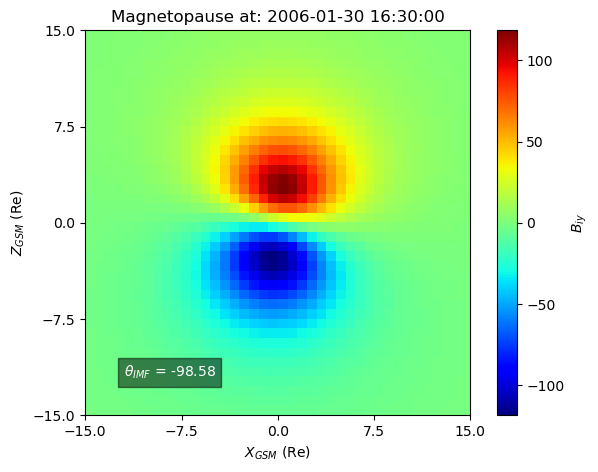

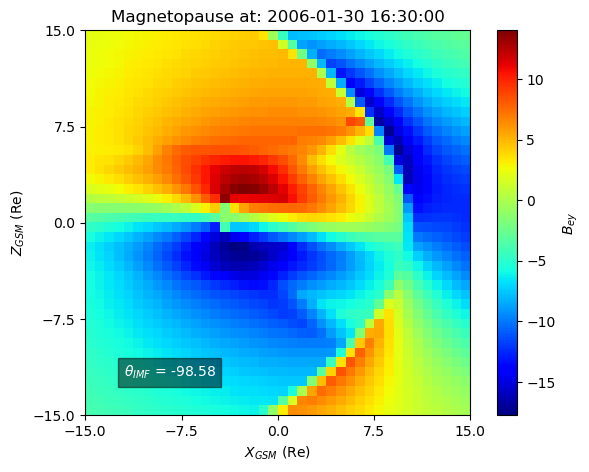

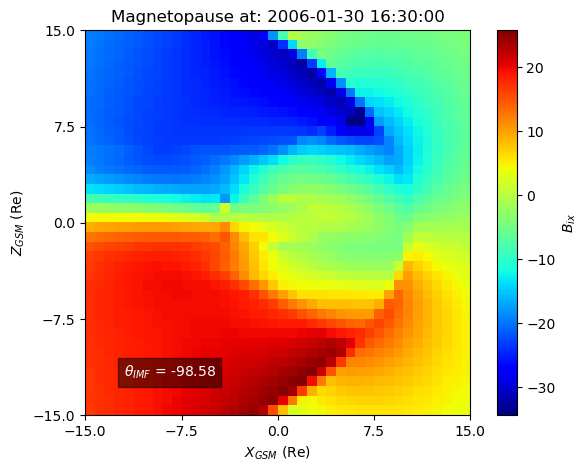

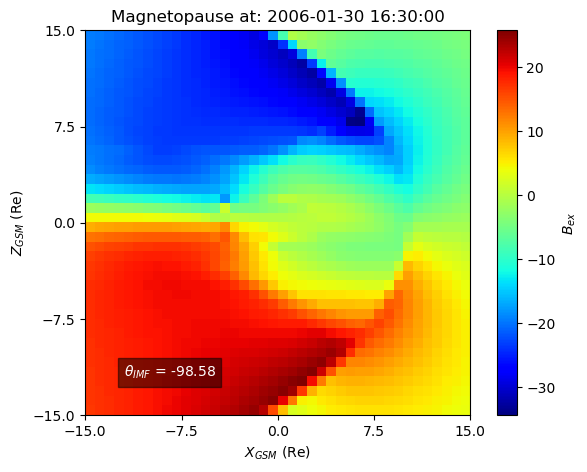

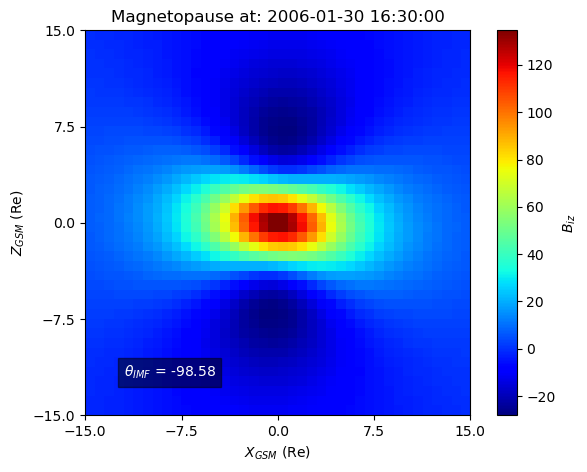

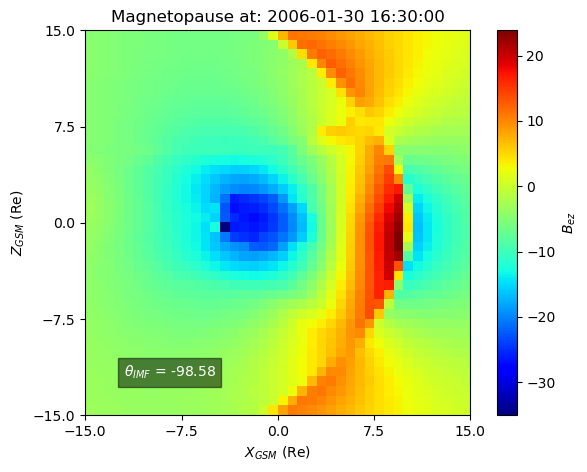

In [336]:

res = 40
var = "xz"
cut = 6
dst = -5
ts = 1

plot_2D_any(df=df1, start_time=stime, probint=5, Dst_val=dst,  timesteps=ts, cut=cut, wtp="biy", var=var, resolution=res)

plot_2D_any(df=df1, start_time=stime, probint=5, Dst_val=dst, timesteps=ts, cut=cut, wtp="bey", var=var, resolution=res)

plot_2D_any(df=df1, start_time=stime, probint=5, Dst_val=dst,  timesteps=ts, cut=cut, wtp="bix", var=var, resolution=res)

plot_2D_any(df=df1, start_time=stime, probint=5, Dst_val=dst, timesteps=ts, cut=cut, wtp="bex", var=var, resolution=res)

plot_2D_any(df=df1, start_time=stime, probint=5, Dst_val=dst,  timesteps=ts, cut=cut, wtp="biz", var=var, resolution=res)

plot_2D_any(df=df1, start_time=stime, probint=5, Dst_val=dst, timesteps=ts, cut=cut, wtp="bez", var=var, resolution=res)



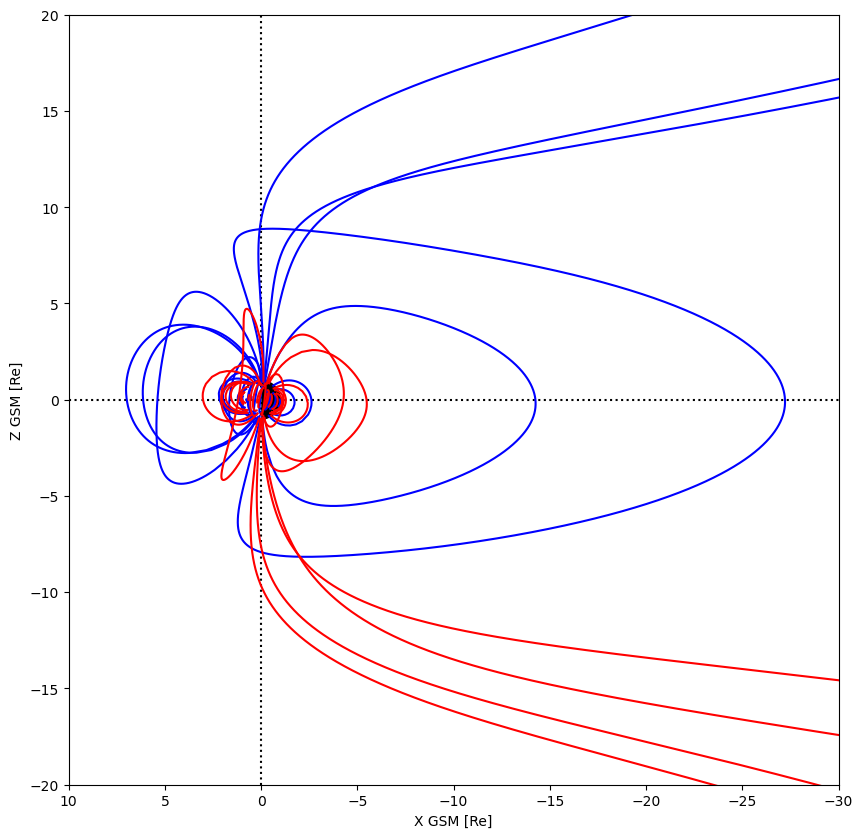

In [341]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Wedge, Circle
import numpy as np

from geopack import geopack

def dual_half_circle(center=(0,0), radius=1, angle=90, ax=None, colors=('w','k','k'),
                     **kwargs):
    """
    Add two half circles to the axes *ax* (or the current axes) with the 
    specified facecolors *colors* rotated at *angle* (in degrees).
    """
    if ax is None:
        ax = plt.gca()
    theta1, theta2 = angle, angle + 180
    #w1 = Wedge(center, radius, theta1, theta2, fc=colors[0], **kwargs)
    #w2 = Wedge(center, radius, theta2, theta1, fc=colors[1], **kwargs)
    
    w1 = Wedge(center, radius, theta1, theta2, fc=colors[1], **kwargs)
    w2 = Wedge(center, radius, theta2, theta1, fc=colors[0], **kwargs)
   
    cr = Circle(center, radius, fc=colors[2], fill=False, **kwargs)
    for wedge in [w1, w2, cr]:
        ax.add_artist(wedge)
    return [w1, w2, cr]

def setup_fig(xlim=(10,-30),ylim=(-20,20),xlabel='X GSM [Re]',ylabel='Z GSM [Re]'):

    fig = plt.figure(figsize=(15,10))
    ax  = fig.add_subplot(111)
    ax.axvline(0,ls=':',color='k')
    ax.axhline(0,ls=':',color='k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_aspect('equal')
    w1,w2,cr = dual_half_circle(ax=ax)
    
    return ax


def generate_random_points_on_hemisphere(hemisphere='north', num_points=1):
    """
    Generate random points on the northern or southern hemisphere of a unit sphere.
    
    Parameters:
    - hemisphere: 'north' or 'south'
    - num_points: number of random points to generate
    
    Returns:
    - x, y, z coordinates of the random points
    """
    x_coords = []
    y_coords = []
    z_coords = []
    
    for _ in range(num_points):
        phi = 2 * np.pi * np.random.rand()  # azimuthal angle
        if hemisphere == 'north':
            theta = np.pi / 2 * np.random.rand()  # polar angle
        else:
            theta = np.pi / 2 + np.pi / 2 * np.random.rand()  # polar angle
        
        # Convert spherical coordinates to Cartesian coordinates
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        
        x_coords.append(x)
        y_coords.append(y)
        z_coords.append(z)
    
    return x_coords, y_coords, z_coords

def trace_and_plot(num_points=5):
    # Generate random points on both hemispheres
    x_north, y_north, z_north = generate_random_points_on_hemisphere('north', num_points)
    x_south, y_south, z_south = generate_random_points_on_hemisphere('south', num_points)
    
    ax = setup_fig()
    
    # Trace and plot field lines for northern hemisphere points
    for x_gsm, y_gsm, z_gsm in zip(x_north, y_north, z_north):
        x, y, z, xx, yy, zz = geopack.trace(x_gsm, y_gsm, z_gsm, dir=1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
        ax.plot(xx, zz, color='blue')  # Using blue for northern hemisphere
    
    # Trace and plot field lines for southern hemisphere points
    for x_gsm, y_gsm, z_gsm in zip(x_south, y_south, z_south):
        x, y, z, xx, yy, zz = geopack.trace(x_gsm, y_gsm, z_gsm, dir=-1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
        ax.plot(xx, zz, color='red')  # Using red for southern hemisphere
    
    plt.show()

# Call the function to trace and plot for a given number of points
trace_and_plot(num_points=30)


In [376]:

# IDEA: Iterate through all points and find boundary, assign 0 to coordinates that trace back to the dipole of the earth
#       and assign 1 to those that don't. If the last or first values of x, y, z have a magnitude of 1 Re, that point in
#       in space takes in value of 0 because it does trace back to earth. and iterate through all space.

def trace_and_plot2(num_points=5):
    # Generate random points on both hemispheres
    x_north, y_north, z_north = generate_random_points_on_hemisphere('north', num_points)
    x_south, y_south, z_south = generate_random_points_on_hemisphere('south', num_points)
    
    ax = setup_fig()
    
    # Trace and plot field lines for northern hemisphere points
    for x_gsm, y_gsm, z_gsm in zip(x_north, y_north, z_north):
        x, y, z, xx, yy, zz = geopack.trace(7, 0, 0, dir=1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
        ax.plot(xx, zz, color='blue')  # Using blue for northern hemisphere
        #print("xx: ", xx)
        #print("zz: ", zz)
    
    # Trace and plot field lines for southern hemisphere points
    for x_gsm, y_gsm, z_gsm in zip(x_south, y_south, z_south):
        x, y, z, xx, yy, zz = geopack.trace(10.933, 0, 0, dir=-1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
        ax.plot(xx, zz, color='red')  # Using red for southern hemisphere
        #print("xx: ", xx)
        #print("zz: ", zz)
    
    plt.show()
trace_and_plot2(1)

xx:  [0.141067   0.14373662 0.14644323 ... 0.33469927 0.32864513 0.32290588]
zz:  [ 0.99        0.99960729  1.00920449 ... -0.96203315 -0.95303693
 -0.94445243]
xx:  [ 0.00000000e+00  9.40790669e-04  1.88130668e-03 ... -7.55501858e+01
 -7.55588665e+01 -7.55675471e+01]
zz:  [ -1.          -1.00984023  -1.01968034 ... -39.49962332 -39.50458854
 -39.5095541 ]


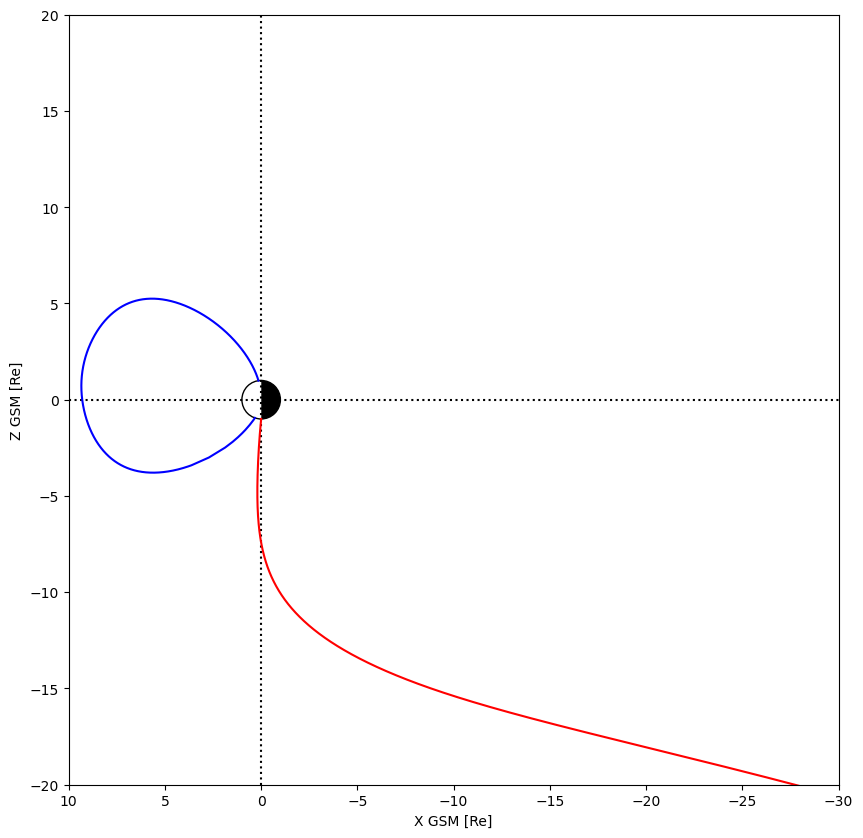

In [380]:
# IDEA: create boundary from points that come exactly from the north or south pole to a degree of tolerance. 
#       the boundary will be created 

def trace_and_plot3(num_points=5):
    # Generate random points on both hemispheres
    x_north, y_north, z_north = generate_random_points_on_hemisphere('north', num_points)
    x_south, y_south, z_south = generate_random_points_on_hemisphere('south', num_points)
    
    ax = setup_fig()
    
    # Trace and plot field lines for northern hemisphere points
    for x_gsm, y_gsm, z_gsm in zip(x_north, y_north, z_north):
        x, y, z, xx, yy, zz = geopack.trace(0.141067, 0, 0.99, dir=1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
        ax.plot(xx, zz, color='blue')  # Using blue for northern hemisphere
        print("xx: ", xx)
        print("zz: ", zz)
    
    # Trace and plot field lines for southern hemisphere points
    for x_gsm, y_gsm, z_gsm in zip(x_south, y_south, z_south):
        x, y, z, xx, yy, zz = geopack.trace(0, 0, -1, dir=-1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
        ax.plot(xx, zz, color='red')  # Using red for southern hemisphere
        print("xx: ", xx)
        print("zz: ", zz)
    
    plt.show()
    
trace_and_plot3(1)

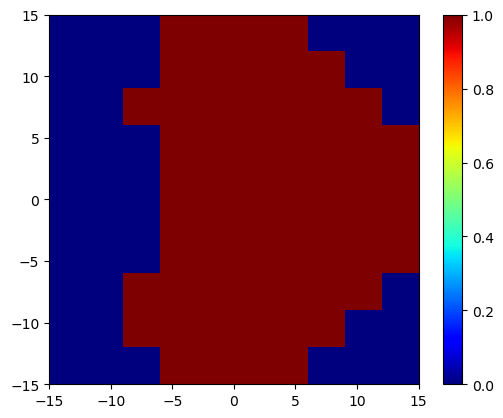

In [487]:
# IDEA: create boundary from points that come exactly from the north or south pole to a degree of tolerance. 
#       the boundary will be created 

def find_boundary(dim=str):
    

    XYZ_Resolution = 10
    Extension = 30
    Ex = Extension/2


    Dx = np.linspace(-Ex, Ex, XYZ_Resolution)
    Dy = np.linspace(-Ex, Ex, XYZ_Resolution)
    Dz = np.linspace(-Ex, Ex, XYZ_Resolution)
    x = y = z = 0 


    magnetopause_boolean = np.zeros((len(Dx), len(Dy), len(Dz)))
    
    if dim == "3D":
        for ix, dx in enumerate(Dx):
            for iy, dy in enumerate(Dy):
                for iz, dz in enumerate(Dz):

                    i, j, k, xx, yy, zz = geopack.trace(x+dx, y+dy, z+dz, dir=-1, rlim=1000000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)

                    if round(np.sqrt(xx[-1]**2+yy[-1]**2+zz[-1]**2)) == 1:  
                        magnetopause_boolean[ix, iy, iz] = 1
                    else:
                        magnetopause_boolean[ix, iy, iz] = 0

                    data = magnetopause_boolean
                    
    elif dim == "2D":
            for iy, dy in enumerate(Dy):
                for iz, dz in enumerate(Dz):

                    i, j, k, xx, yy, zz = geopack.trace(x+dx, y+dy, z+dz, dir=-1, rlim=1000000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)

                    if round(np.sqrt(xx[-1]**2+yy[-1]**2+zz[-1]**2)) == 1:  
                        magnetopause_boolean[ix, iy, iz] = 1
                    else:
                        magnetopause_boolean[ix, iy, iz] = 0

                    data = magnetopause_boolean

    plt.imshow(data[4, :, :], cmap='jet', vmin=0, vmax=1, extent=[-Ex, Ex, -Ex, Ex])  # extent is used to define the span of x and y axes

    plt.colorbar()
                
                

    
    
find_boundary(dim="3D")